# StarDist Data Preprocessing

This notebook preprocesses raw frame images for StarDist training using individual and combined methods:

**Individual Methods:**
1. **Flatfield Correction**: Removes uneven background illumination.
2. **DoG (Difference of Gaussians)**: Enhances edges and removes background (Soft, Medium, Sharp).
3. **Lanczos Upscaling**: Resizes images for higher resolution.

**Combined Methods:**
4. **Flatfield + Lanczos**
5. **Flatfield + DoG Soft**
6. **Flatfield + DoG Soft + Lanczos**
7. **DoG Soft + Lanczos**

**Input**: `data/Preprocess/frames`
**Output**: `data/Preprocess/result`

In [17]:
# Install dependencies in the current kernel
%pip install opencv-python
%pip install matplotlib
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
import cv2
import numpy as np
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# Configuration
BASE_DIR = os.path.abspath('')
INPUT_DIR = os.path.join(BASE_DIR, 'data', 'Preprocess', 'frames')
OUTPUT_DIR = os.path.join(BASE_DIR, 'data', 'Preprocess', 'result')
FLAT_FRAME_DIR = os.path.join(BASE_DIR, 'data', 'Preprocess', 'flat_frame')

# Ensure output directories exist
dirs_to_create = [
    FLAT_FRAME_DIR,
    os.path.join(OUTPUT_DIR, 'flatfield'),
    os.path.join(OUTPUT_DIR, 'dog', 'soft'),
    os.path.join(OUTPUT_DIR, 'dog', 'medium'),
    os.path.join(OUTPUT_DIR, 'dog', 'sharp'),
    os.path.join(OUTPUT_DIR, 'lanczos'),
    os.path.join(OUTPUT_DIR, 'flatfield_lanczos'),
    os.path.join(OUTPUT_DIR, 'flatfield_dog_soft'),
    os.path.join(OUTPUT_DIR, 'flatfield_dog_soft_lanczos'),
    os.path.join(OUTPUT_DIR, 'dog_soft_lanczos')
]

for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

print(f"Input Directory: {INPUT_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Flat Frame Directory: {FLAT_FRAME_DIR}")

Input Directory: e:\PTIT\Doan\CodeRepo\data\Preprocess\frames
Output Directory: e:\PTIT\Doan\CodeRepo\data\Preprocess\result
Flat Frame Directory: e:\PTIT\Doan\CodeRepo\data\Preprocess\flat_frame


## Utility Functions

In [19]:
def load_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def save_image(img, folder, filename):
    path = os.path.join(folder, filename)
    cv2.imwrite(path, img)

def get_image_files(directory):
    extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif')
    files = []
    for ext in extensions:
        files.extend(glob.glob(os.path.join(directory, ext)))
    return sorted(files)

def upscale_nearest(img, scale_factor=2.0):
    """Upscale image using Nearest Neighbor interpolation."""
    width = int(img.shape[1] * scale_factor)
    height = int(img.shape[0] * scale_factor)
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    
def upscale_lanczos(img, scale_factor=2.0):
    width = int(img.shape[1] * scale_factor)
    height = int(img.shape[0] * scale_factor)
    return cv2.resize(img, (width, height), interpolation=cv2.INTER_LANCZOS4)

def apply_dog_cl(img, sigma1=1.0, sigma2=20.0, clahe_clip=None):
    img_float = img.astype(np.float32)
    g1 = cv2.GaussianBlur(img_float, (0, 0), sigma1)
    g2 = cv2.GaussianBlur(img_float, (0, 0), sigma2)
    dog = g1 - g2
    dog_norm = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    if clahe_clip is not None and clahe_clip > 0:
        clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8,8))
        return clahe.apply(dog_norm)
    return dog_norm

def create_master_flat(image_paths, max_frames=200):
    print("Generating master flat frame...")
    selected_paths = image_paths
    if len(image_paths) > max_frames:
        step = len(image_paths) // max_frames
        selected_paths = image_paths[::step]
    
    images = []
    first_img = load_image(selected_paths[0])
    h, w = first_img.shape
    
    for path in tqdm(selected_paths, desc="Loading for Flat"):
        img = load_image(path)
        if img is None: continue
        if img.shape != (h, w):
            img = cv2.resize(img, (w, h))
        images.append(img)
        
    stack = np.array(images, dtype=np.uint8)
    flat = np.median(stack, axis=0).astype(np.uint8)
    return flat

def apply_flatfield(img, flat):
    flat_float = flat.astype(np.float32)
    flat_mean = np.mean(flat_float)
    flat_float[flat_float == 0] = 0.0001 # Avoid div by zero
    
    img_float = img.astype(np.float32)
    corrected = (img_float / flat_float) * flat_mean
    return np.clip(corrected, 0, 255).astype(np.uint8)

## Phase 1: Individual Methods Execution

1. **Flatfield**
2. **DoG Variations**
3. **Lanczos**

In [20]:
files = get_image_files(INPUT_DIR)

if files:
    # --- 1. Flatfield ---
    master_flat = create_master_flat(files)
    cv2.imwrite(os.path.join(FLAT_FRAME_DIR, "master_flat.png"), master_flat)
    
    output_flat_dir = os.path.join(OUTPUT_DIR, 'flatfield')
    print(f"Applying Flatfield to {len(files)} images...")
    for path in tqdm(files, desc="Flatfield"):
        img = load_image(path)
        if img is None: continue
        if img.shape != master_flat.shape:
             img = cv2.resize(img, (master_flat.shape[1], master_flat.shape[0]))   
        res = apply_flatfield(img, master_flat)
        save_image(res, output_flat_dir, os.path.basename(path))
        
    # --- 2. DoG Variations ---
    variations = {
        "soft": {"sigma1": 2.0, "sigma2": 20.0, "clahe": None},
        "medium": {"sigma1": 1.5, "sigma2": 20.0, "clahe": 1.5},
        "sharp": {"sigma1": 1.0, "sigma2": 20.0, "clahe": 3.0}
    }
    print(f"Applying DoG variations...")
    for name, params in variations.items():
        output_subdir = os.path.join(OUTPUT_DIR, 'dog', name)
        for path in tqdm(files, desc=f"DoG-{name}"):
            img = load_image(path)
            if img is None: continue
            res = apply_dog_cl(img, sigma1=params["sigma1"], sigma2=params["sigma2"], clahe_clip=params["clahe"])
            save_image(res, output_subdir, os.path.basename(path))

    # --- 3. Lanczos ---
    output_lanczos_dir = os.path.join(OUTPUT_DIR, 'lanczos')
    SCALE_FACTOR = 2.0
    print(f"Applying Lanczos Upscale...")
    for path in tqdm(files, desc="Lanczos"):
        img = load_image(path)
        if img is None: continue
        res = upscale_lanczos(img, SCALE_FACTOR)
        save_image(res, output_lanczos_dir, os.path.basename(path))
else:
    print("No input images found!")

Generating master flat frame...


Loading for Flat: 100%|██████████| 222/222 [00:01<00:00, 139.21it/s]


Applying Flatfield to 886 images...


Flatfield: 100%|██████████| 886/886 [00:14<00:00, 59.89it/s]


Applying DoG variations...


DoG-sharp: 100%|██████████| 886/886 [00:13<00:00, 64.20it/s]


Applying Lanczos Upscale...


Lanczos: 100%|██████████| 886/886 [00:16<00:00, 54.48it/s]


## Phase 2: Combined Methods Execution (Disk-Based)

Uses output from Phase 1 as input to save RAM.

4. **Flatfield + Lanczos**
5. **Flatfield + DoG Soft**
6. **Flatfield + DoG Soft + Lanczos**
7. **DoG Soft + Lanczos**

In [21]:
if files:
    # Directories
    flat_dir = os.path.join(OUTPUT_DIR, 'flatfield')
    dog_soft_dir = os.path.join(OUTPUT_DIR, 'dog', 'soft')
    
    out_flat_lanczos = os.path.join(OUTPUT_DIR, 'flatfield_lanczos')
    out_flat_dog = os.path.join(OUTPUT_DIR, 'flatfield_dog_soft')
    out_flat_dog_lanczos = os.path.join(OUTPUT_DIR, 'flatfield_dog_soft_lanczos')
    out_dog_lanczos = os.path.join(OUTPUT_DIR, 'dog_soft_lanczos')

    print("Applying Combined Methods (Reading from Disk)...")
    
    dog_soft_params = variations["soft"]
    
    for path in tqdm(files, desc="Combined"):
        filename = os.path.basename(path)
        
        # 1. Load Flatfield Corrected Image (from Disk)
        img_flat = load_image(os.path.join(flat_dir, filename))
        
        # 2. Load DoG Soft Image (from Disk)
        img_dog_soft = load_image(os.path.join(dog_soft_dir, filename))
        
        if img_flat is None:
             print(f"Warning: Missing flatfield image for {filename}")
             continue
             
        # -- Workflow 1: Flatfield + Lanczos --
        # Input: Flatfield Image -> Lanczos
        res4 = upscale_lanczos(img_flat, 2.0)
        save_image(res4, out_flat_lanczos, filename)
        
        # -- Workflow 2: Flatfield + DoG Soft --
        # Input: Flatfield Image -> DoG Soft
        res5 = apply_dog_cl(img_flat, 
                            sigma1=dog_soft_params["sigma1"], 
                            sigma2=dog_soft_params["sigma2"], 
                            clahe_clip=dog_soft_params["clahe"])
        save_image(res5, out_flat_dog, filename)
        
        # -- Workflow 3: Flatfield + DoG Soft + Lanczos --
        # Input: (Flatfield + DoG Soft) Result -> Lanczos
        res6 = upscale_lanczos(res5, 2.0)
        save_image(res6, out_flat_dog_lanczos, filename)
        
        # -- Workflow 4: DoG Soft + Lanczos (No Flatfield) --
        # Input: DoG Soft Image (from Disk) -> Lanczos
        if img_dog_soft is not None:
            res7 = upscale_lanczos(img_dog_soft, 2.0)
            save_image(res7, out_dog_lanczos, filename)
        
    print("Combined methods done.")

Applying Combined Methods (Reading from Disk)...


Combined: 100%|██████████| 886/886 [01:12<00:00, 12.18it/s]

Combined methods done.


## Visual Validation

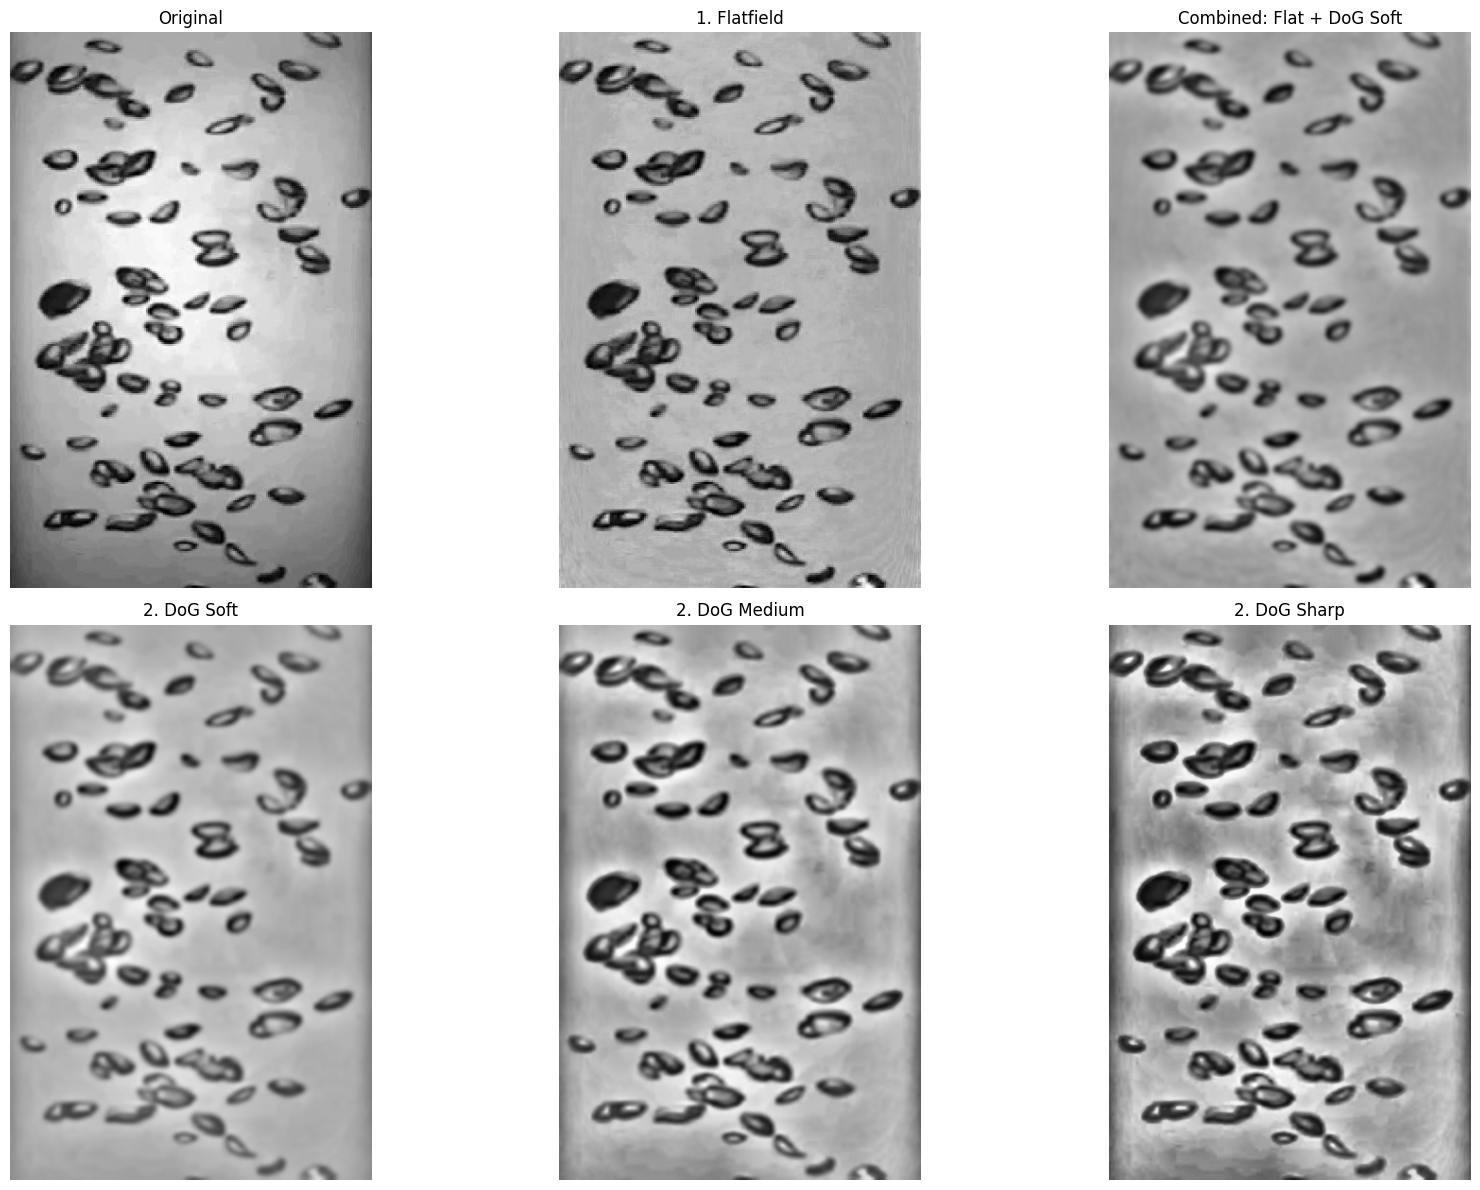

In [22]:
def show_preview(idx=0):
    if not files: return
    fname = os.path.basename(files[idx])
    
    # helper to load safe
    def load_safe(subdir):
        p = os.path.join(OUTPUT_DIR, subdir, fname)
        i = load_image(p)
        if i is None: return np.zeros((100,100), dtype=np.uint8)
        return i

    # Load Variations (Excluding Lanczos)
    img_orig = load_image(files[idx])
    if img_orig is None: img_orig = np.zeros((100,100), dtype=np.uint8)
    
    img_flat = load_safe('flatfield')
    img_dog_s = load_safe(os.path.join('dog', 'soft'))
    img_dog_m = load_safe(os.path.join('dog', 'medium'))
    img_dog_h = load_safe(os.path.join('dog', 'sharp'))
    img_flat_dog = load_safe('flatfield_dog_soft')
    
    # 6 Images, 3 per row => 2 rows
    images = [
        (img_orig, "Original"),
        (img_flat, "1. Flatfield"),
        (img_flat_dog, "Combined: Flat + DoG Soft"),
        (img_dog_s, "2. DoG Soft"),
        (img_dog_m, "2. DoG Medium"),
        (img_dog_h, "2. DoG Sharp")
    ]
    
    import math
    cols = 3
    rows = math.ceil(len(images) / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
    ax = axes.ravel()
    
    for i in range(len(ax)):
        if i < len(images):
            img, title = images[i]
            ax[i].imshow(img, cmap='gray')
            ax[i].set_title(title)
            ax[i].axis('off')
        else:
            ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

if files:
    show_preview(0)